<a href="https://colab.research.google.com/github/QABoahene/Real-Estate-Price-Prediction/blob/master/Real_Estate_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is to predict the real estate prices or bids for houses in Bengaluru, India.

This is my commented version following a playlist of tutorial for this project. Find the tutorial here: https://www.youtube.com/playlist?list=PLeo1K3hjS3uu7clOTtwsp94PcHbzqpAdg
Dataset: https://www.kaggle.com/amitabhajoy/bengaluru-house-price-data

In [0]:
#Importing Libraries
import pandas as pd
import io
import numpy as np
import pickle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)

In [2]:
#This is to upload files from my local disk
from google.colab import files
uploaded = files.upload()

Saving Bengaluru_House_Data.csv to Bengaluru_House_Data.csv


In [0]:
real_estate = pd.read_csv(io.BytesIO(uploaded['Bengaluru_House_Data.csv']))
# Dataset is now stored in a Pandas Dataframe

In [4]:
real_estate.head(5)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [5]:
real_estate.shape #This shows the number of columns and the number of rows in the dataset. 

(13320, 9)

In [6]:
real_estate.columns #I am now showing the column names of the dataset as this will help us navigate through it during feature extraction. 

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [7]:
'''
This is to examine the feature 'area_type'.
That feature is in categories so the code below groups a list 'area_type' 
by it's categories then aggregrate to give the count of each categories.
'''
real_estate.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

Now, it isn't all the columns above that is important to us. So columns from the dataset will be dropped in order to begin the cleaning process of the dataset. Note that you should be **very sure** that the columns you're dropping won't be important during feature engineering.

We assume that area_type, availability, society and balcony will not affect the price of the building. This is only assumed. You have to ask yourself or your employer whether a feature is important or not. Sometimes a column/feature may not be important but that could help you in feature engineering to create new features. This also depends on how well you know your data so take time and go through the columns of a dataset, what it was collected for and what you want to achieve with it. That will help you decide. 

In [8]:
clean_estate = real_estate.drop(['area_type','society','balcony','availability'], axis = 'columns')

'''So here, remember that if it was just a column that we were dropping, it will just be "....('column_name')
but the square brackets were used because we were providing a list of columns to be deleted simultaneously.
the 'axis = columns' shows that we want to delete the columns. 
It could be coded as 'axis = 1', this is the same as axis = columns.'''

clean_estate.head(5)

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [9]:
clean_estate.isnull().sum() #This code will be showing us the sum (.sum()) of all the empty values in the columns. 

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

This shows us the degree of missing values we have in a column. With this, you'll be able to inform your decision to clean the data. With this kind of cleaning, you can decide to drop the rows if the amount of missing value is not too high. Also, you can decide to fill the missing values with the median values of the column. 
Remember that this has the potential of affecting the effectiveness of your dataset so you have to make this decision carefully.

In [10]:
cl_estate = clean_estate.dropna() #This drops the rows that are null
cl_estate.isnull().sum() 

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [11]:

#We can now have a look at the shape of the dataset after this part of the cleaning. 
cl_estate.shape

(13246, 5)

Now, looking at the size column, we can see that the data has different types of inputs. It is important that we explore it and make cleaning decisions about it. 

In [12]:
cl_estate['size'].unique() #This will give you a pandas series and then call the unique values of the column

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

Note that there are values with '4 BHK' and '4 Bedroom'. These are essentially the same and you have to always be on the look out for such problems in the dataset. some things may be the same but because of bad labelling, they might end up being differentiaed and this can affect the quality of your dataset.  A new column will be created to help deal with this problem. 

In [13]:
cl_estate['bhk'] = cl_estate['size'].apply(lambda x: int(x.split(' ')[0]))
cl_estate.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


Now the above may seem a bit too much because I'm a beginner in both Python and Data Science but here is the best possible way I understood it. 
So with this, we created a new column called 'bhk' and this was based of the pre-existing 'size' column. since we stated above that same sizes were split into 2 because of their strings, we will be applying a function which will help us tokenize the strings and pick what we want exactly from the string. We will use the lambda function. Here's the thing, we will be tokenizing the string with space(' '). So we will be spliting the string input with spaces and then we will choose which one we will like. In this case we will be dealing with the numbers only since '4 Bedroom' is the same as '4 bhk'. The code above shows that the new column was created based off the size column and the lambda function was applied and then the spliting of the x values (which are the inputs) was done with spaces. Then [0] was chosen since that will be the first value we need from the spring. Now when dealing with the numbers which are tokenized as strings, we will be making them integers again to make the data appropriate to work with, hence the (....int(...)) part of the code.

In [14]:
cl_estate['bhk'].unique() 
'''This now shows just the various numbers of bhk categoeries 
there are in the dataset and this looks cleaner and simpler than before'''

'This now shows just the various numbers of bhk categoeries \nthere are in the dataset and this looks cleaner and simpler than before'

In [15]:
cl_estate[cl_estate.bhk>15]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
3379,1Hanuman Nagar,19 BHK,2000,16.0,490.0,19
3609,Koramangala Industrial Layout,16 BHK,10000,16.0,550.0,16
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43
11559,1Kasavanhalli,18 Bedroom,1200,18.0,200.0,18


Looking at the table above, you can see that some of the houses has a high bhk but the total square foot can be very questionable compared to that of the houses with high bhk. This will need some exploring. Always check your data presentation and try to find the next thing you can do to make your data better. 

In [16]:
cl_estate.total_sqft.unique #Again, this displays the unique values of the total_sqft column

<bound method Series.unique of 0        1056
1        2600
2        1440
3        1521
4        1200
         ... 
13315    3453
13316    3600
13317    1141
13318    4689
13319     550
Name: total_sqft, Length: 13246, dtype: object>

With the variations, there are some ranges in the total_sqft column. This is not good for processing. A function is defined to detect if a given value in the column is float or not. 
The way the function works is that it will try to convert a given value (x) in the total_sqft column into float and if it isn't a valued value, it will be brought into the except where it will be returned as false or true.  

In [0]:
def is_float(x):
  try:
    float(x)
  except:
    return False
  return True

In [18]:
cl_estate[~cl_estate['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


There are many times that when cleaning a dataset, you come across things like we have in the total_sqft column. As you can see, there are ranges and inputs like '34.46Sq. Meter'. We have to be able to get constant input in order to make the dataset easier to deal with. 
So in this dataset, the way we will deal with the ranges will be that when we have a range, we take the average of the range. Rows with inputs like '34.46Sq. Meter' and '4125Perch' will be ignored. For a more robust and efficient data, you can do unit convesions for the other inputs mentioned above.
For now we will just deal with the ranges only. 

In [0]:
def convert_sqft(x): #Inputs string (x) is taken here
  tokens = x.split('-') #The string is split using ('-')
  if len(tokens) == 2: #So if the token is two
    return (float(tokens[0])+float(tokens[1]))/2 #Then the tokens are taken and the average is calculated for
  try:
    return float(x)
  except:
    return None
#If not, then the ssingle input will be converted to float 

Trials

In [20]:
convert_sqft('2345') #The function will convert the simple string into a float. 

2345.0

In [21]:
convert_sqft('1015 - 1540') #The function will get the average of this and then return it as a float

1277.5

In [22]:
#Confirmation
A = (1015 + 1540)/2
A

1277.5

In [23]:
#Now we will apply the function to the 'total_sqft' column
cl_estate2 = cl_estate.copy() #We create a deep copy of the dataset 
cl_estate2['total_sqft'] = cl_estate2['total_sqft'].apply(convert_sqft)
cl_estate2.head(10)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2
5,Whitefield,2 BHK,1170.0,2.0,38.00,2
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3
9,Gandhi Bazar,6 Bedroom,1020.0,6.0,370.00,6


In [24]:
#Now we check for a particular range input for verification of conversion
cl_estate2.loc[549]

location      Hennur Road
size                2 BHK
total_sqft         1317.5
bath                    2
price               63.77
bhk                     2
Name: 549, dtype: object

In [25]:
#Confirmation
(1195 + 1440)/2

1317.5

## Feature Engineering


Just as discussed above, feature engineering helps us to create features from the dataset which can help us make our dataset more efficient. So for this dataset, we created the price per square foot because this can help predict the prices accurately.

In [26]:
cl_estate3 = cl_estate2.copy()
cl_estate3['price_per_sqft'] = cl_estate3['price']*100000/cl_estate3['total_sqft']
cl_estate3.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [27]:
cl_estate3.location.unique() #This shows the unique locations in the column 

array(['Electronic City Phase II', 'Chikka Tirupathi', 'Uttarahalli', ...,
       '12th cross srinivas nagar banshankari 3rd stage',
       'Havanur extension', 'Abshot Layout'], dtype=object)

In [28]:
len(cl_estate3.location.unique()) #This shows the number of locations in the column

1304

The above is a high dimensionality issue because having that many locations will make it have a lot of columns and some of these locations may have one or two data points. 

In [29]:
#This is how I find the above
cl_estate3.location = cl_estate3.location.apply(lambda x: x.strip()) #This strips down any spaces in the location column
location_stats = cl_estate3.groupby('location')['location'].agg('count').sort_values(ascending = False) #The stats on the data points of the locations
location_stats

location
Whitefield           535
Sarjapur  Road       392
Electronic City      304
Kanakpura Road       266
Thanisandra          236
                    ... 
LIC Colony             1
Kuvempu Layout         1
Kumbhena Agrahara      1
Kudlu Village,         1
1 Annasandrapalya      1
Name: location, Length: 1293, dtype: int64

In [30]:
len(location_stats[location_stats<=10]) #This shows the number of locations with less than 10 data points in the dataset

1052

In [31]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10 #We now create a new dataframe for the locations with less than 10 rows
#This will be later on put in a category called 'other'.

location
BTM 1st Stage          10
Basapura               10
Sector 1 HSR Layout    10
Naganathapura          10
Kalkere                10
                       ..
LIC Colony              1
Kuvempu Layout          1
Kumbhena Agrahara       1
Kudlu Village,          1
1 Annasandrapalya       1
Name: location, Length: 1052, dtype: int64

In [32]:
len(cl_estate3.location.unique()) #This is the number of locations in 'cl_estate3'.

1293

In [33]:
cl_estate3.location = cl_estate3.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(cl_estate3.location.unique())
#A transformation is applied which will put a location in category 'other' if it has less than 10 data points
#The locations are now reduced to 242 locations which can be worked with because of the dimensionality reduction done.

242

In [34]:
cl_estate3.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


## Outlier Detection and removal
Outliers are the data points which are errors, usually not all are errors but then they represent extreme variations in a dataset. They are valid but then they have the possibilities to create problems so removing them can be essential.
This can take some techniques and it also can depend on some domain expertise.

In [35]:
#Rows in the dataset
cl_estate3.shape

(13246, 7)

In [36]:
cl_estate4 = cl_estate3[~(cl_estate3.total_sqft/cl_estate3.bhk<300)] #Negating the data rows which were filtered
cl_estate4.shape

(12502, 7)

In [37]:
cl_estate4.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [0]:
#Removing price per square foot outliers per location
def del_pps_outliers(cl_estate): #Taking input
  cl_estate_out = pd.DataFrame()
  for key, sub_cl_estate in cl_estate.groupby('location'): #Grouping by location
    m =  np.mean(sub_cl_estate.price_per_sqft) #Calculating mean per location
    st = np.std(sub_cl_estate.price_per_sqft) #Calculating standard deviation per location
    reduced_cl_estate = sub_cl_estate[(sub_cl_estate.price_per_sqft>(m-st)) & (sub_cl_estate.price_per_sqft<=(m+st))]
    #Filtering data points which are beyond the standard deviation
    cl_estate_out = pd.concat([cl_estate_out, reduced_cl_estate], ignore_index=True)
  return cl_estate_out

In [39]:
 cl_estate5 = del_pps_outliers(cl_estate4)
 cl_estate5.shape

(10241, 7)

In [0]:
def scat_plot (cl_estate, location):
  bhk2 = cl_estate[(cl_estate.location==location) & (cl_estate.bhk==2)]
  bhk3 = cl_estate[(cl_estate.location==location) & (cl_estate.bhk==3)]
  #The above of the function two dataframes
  matplotlib.rcParams['figure.figsize'] = (15,10)
  plt.scatter(bhk2.total_sqft,bhk2.price,color = 'red', label = '2 BHK', s = 50)
  plt.scatter(bhk3.total_sqft,bhk3.price,marker='*', color = 'blue', label = '3 BHK', s = 50)
  #Creating a scatter plot
  plt.xlabel("TOTAL SQUARE FOOT AREA")
  plt.ylabel("PRICE")
  plt.title(location)
  plt.legend()

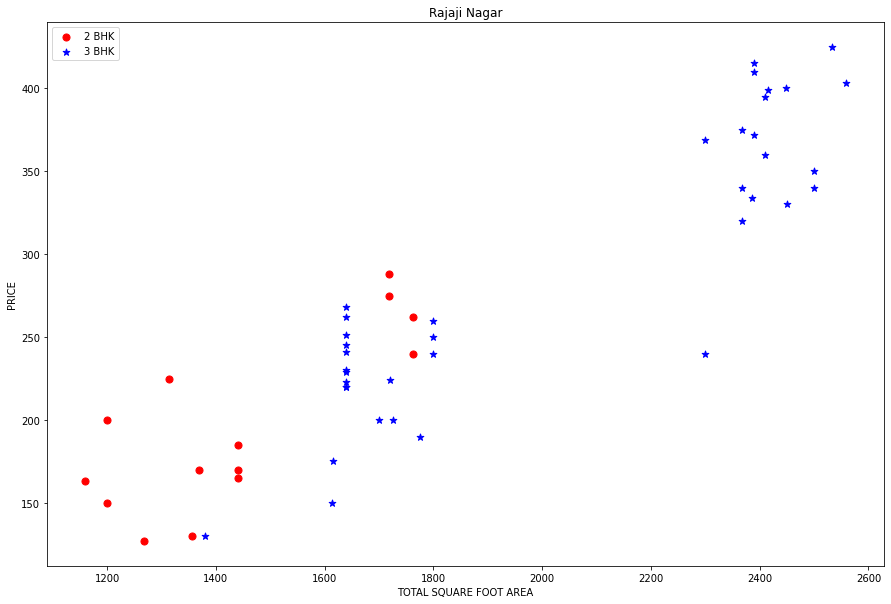

In [42]:
scat_plot(cl_estate5, "Rajaji Nagar")

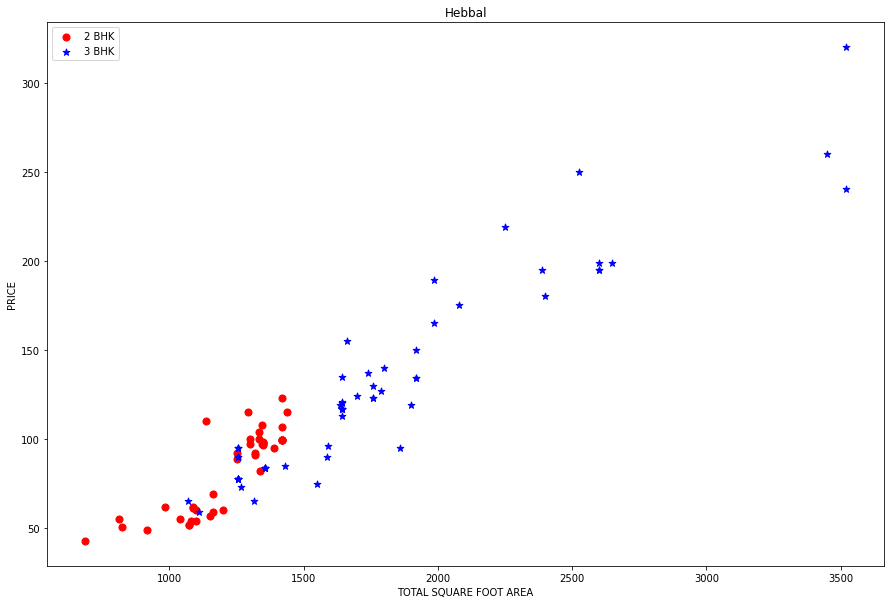

In [44]:
scat_plot(cl_estate5, "Hebbal")

Per further analysis, we have to create a function that will also remove properties that are in the same location that has inconsistencies in pricing regarding to how it relates to the bedrooms.
For example, If the price of a three bedroom house is lesser than a two bedroom apartment but has the same sqare foot area. This is treated as an outlier because it is based on the locations and also domain expertise in real estate.

A dictionary is created for the stats per bhk for a specific location.

{
  '1' : {
    'mean': 4000,
    'std': 2000,
    'count': 34
  },
  '2' : {
    'mean': 4300,
    'std': 2300,
    'count': 22
  },
}

Now the 2 BHK houses which has price per sqare foot less than the mean price per square feet of 1BHK can be removed.

In [45]:
#A function to delete BHK outliers
def del_bhk_outliers(cl_estate):
  exclude_indices = np.array([])
  for location, location_cl_estate in cl_estate.groupby('location'): #Grouping by location (every location dataframe)
    bhk_stats = {}
    for bhk, bhk_cl_estate in location_cl_estate.groupby('bhk'): #Creating new dataframes per bhk
      bhk_stats[bhk] = {
          'mean': np.mean(bhk_cl_estate.price_per_sqft),
          'std': np.std(bhk_cl_estate.price_per_sqft),
          'count': bhk_cl_estate.shape[0]
          #Calculating mean, standard deviation and count per bhk
      }
    for bhk, bhk_cl_estate in location_cl_estate.groupby('bhk'):
      stats = bhk_stats.get(bhk-1)
      if stats and stats['count'] > 5:
        exclude_indices = np.append(exclude_indices, bhk_cl_estate[bhk_cl_estate.price_per_sqft<(stats['mean'])].index.values)
  return cl_estate.drop(exclude_indices, axis = 'index')
  #Excluding data points with price per square feet less than the mean of the previous

cl_estate6 = del_bhk_outliers(cl_estate5)
cl_estate6.shape

(7329, 7)

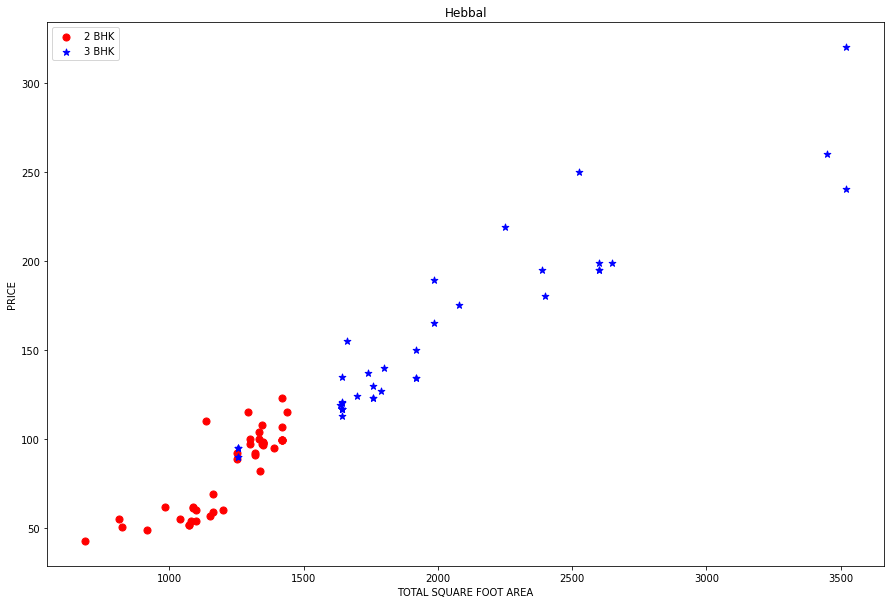

In [46]:
#Plotting the same scatter plot to compare the outliers
scat_plot(cl_estate6, "Hebbal")

Text(0.5, 1.0, 'HISTOGRAM OF PROPERTIES PER PRICE PER SQUARE FOOT')

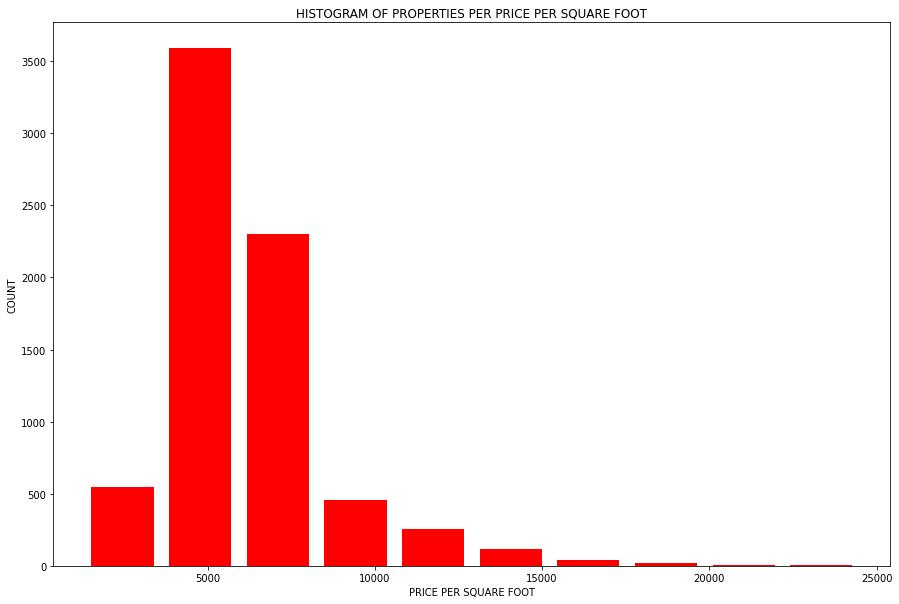

In [47]:
#Plotting a histogram to show how many properties there are per square feet area
matplotlib.rcParams["figure.figsize"] = (15,10)
plt.hist(cl_estate6.price_per_sqft, rwidth=0.8, color='red')
plt.xlabel("PRICE PER SQUARE FOOT")
plt.ylabel("COUNT")
plt.title("HISTOGRAM OF PROPERTIES PER PRICE PER SQUARE FOOT")

This distribution looks fine, normalised.

In [48]:
#Exploring the bathroom feature
cl_estate6.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

In [49]:
#Checking for the apartments with bathrooms more than ten(10)
cl_estate6[cl_estate6.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8486,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8575,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9308,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9639,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


Domain expertise will be able to tell you the things you need to know to deal with the bathroom feature.
For example, it wouldn't make sense to have 4 bathrooms in a house with one or two bedrooms. That's quite unusual. So this can be worked on, especially if the square foot area is less.

Text(0.5, 1.0, 'BATHROOM COUNT')

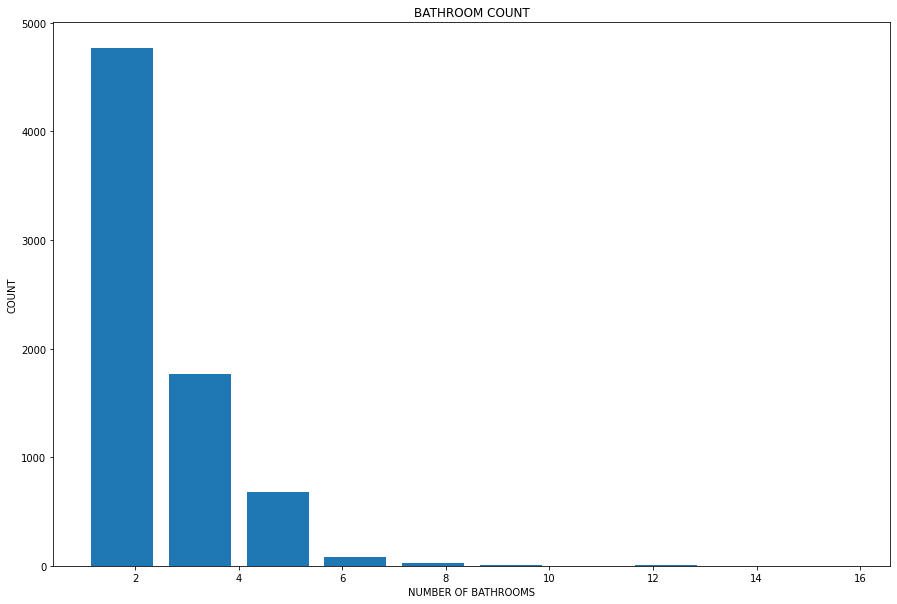

In [50]:
#Exploring the bath feature with a histogram
plt.hist(cl_estate6.bath, rwidth=0.8)
plt.xlabel("NUMBER OF BATHROOMS")
plt.ylabel("COUNT")
plt.title("BATHROOM COUNT")

Now per the example above, we can say that any house with bathrooms greater (+2) than the number of bedrooms is or can be treated as an outlier. 

In [51]:
cl_estate6[cl_estate6.bath>cl_estate6.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8411,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


In [52]:
cl_estate7 = cl_estate6[cl_estate6.bath<cl_estate6.bhk+2]
cl_estate7.shape

(7251, 7)

Now that the data is clean enough, it can be prepared for machine learning training. This means some features would have to be further dropped. Note that some features were kept to be able to inform how we treat other important features so always be informed about your features and how to drop them and when.

In [53]:
#Creating a new dataframe without the dropped features for the machine learning training
final_data = cl_estate7.drop(['size', 'price_per_sqft'], axis='columns')
final_data.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


# Model Building

Machine learning models can't interpret text data so the loctation columnn in the dataset would be transformed to numerical data. Since the location names are not categorized and are many, they will be transformed into dummy inputs. 
Pandas dummy method will be used. 

In [61]:
dummies = pd.get_dummies(final_data['location'])
dummies.head(5)
'''This creates dummy values for all the locations which
are turned into columns for this to take effect.'''

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BEML Layout,BTM 2nd Stage,BTM Layout,Babusapalaya,Badavala Nagar,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,Banashankari Stage VI,Banaswadi,Banjara Layout,Bannerghatta,Bannerghatta Road,Basavangudi,Basaveshwara Nagar,...,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Thyagaraja Nagar,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [63]:
final_data2 = pd.concat([final_data, dummies.drop('other', axis = 1)], axis = 1)
final_data2.head(5)

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BEML Layout,BTM 2nd Stage,BTM Layout,Babusapalaya,Badavala Nagar,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,Banashankari Stage VI,Banaswadi,...,Sanjay nagar,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Thyagaraja Nagar,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [65]:
final_data3 = final_data2.drop('location', axis = 1)
final_data3.head(5)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BEML Layout,BTM 2nd Stage,BTM Layout,Babusapalaya,Badavala Nagar,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,Banashankari Stage VI,Banaswadi,Banjara Layout,...,Sanjay nagar,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Thyagaraja Nagar,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [66]:
final_data3.shape

(7251, 245)

In [67]:
X = final_data3.drop('price', axis = 1) #Dropping the price because that is what we want to predict, leaving the depending variables
X.head()

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Amruthahalli,Anandapura,Ananth Nagar,Anekal,Anjanapura,Ardendale,Arekere,Attibele,BEML Layout,BTM 2nd Stage,BTM Layout,Babusapalaya,Badavala Nagar,Balagere,Banashankari,Banashankari Stage II,Banashankari Stage III,Banashankari Stage V,Banashankari Stage VI,Banaswadi,Banjara Layout,Bannerghatta,...,Sanjay nagar,Sarakki Nagar,Sarjapur,Sarjapur Road,Sarjapura - Attibele Road,Sector 2 HSR Layout,Sector 7 HSR Layout,Seegehalli,Shampura,Shivaji Nagar,Singasandra,Somasundara Palya,Sompura,Sonnenahalli,Subramanyapura,Sultan Palaya,TC Palaya,Talaghattapura,Thanisandra,Thigalarapalya,Thubarahalli,Thyagaraja Nagar,Tindlu,Tumkur Road,Ulsoor,Uttarahalli,Varthur,Varthur Road,Vasanthapura,Vidyaranyapura,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [68]:
Y = final_data3.price
Y.head()

0    428.0
1    194.0
2    235.0
3    130.0
4    148.0
Name: price, dtype: float64

In [0]:
#Dividing the dataset into training and test samples
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 10) # 20% will be for test sample

In [76]:
''' A linear regresion model is created,
a fit method is is called on X and Y train and 
a score is evaluated which will tell us how good our model is.'''

lr_clf = LinearRegression()
lr_clf.fit(X_train, Y_train)
lr_clf.score(X_test,Y_test)

0.8452277697874303

The score is about 84% and as usual a couple of models with different parameters will be tried to give the best optimal model.

First we use K Fold cross validation

In [83]:
Cross_Val = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0) #Creating a Shuffle split which will randomize the sample for equal distribution
cross_val_score(LinearRegression(), X, Y, cv = Cross_Val) 

array([0.82430186, 0.77166234, 0.85089567, 0.80837764, 0.83653286])

Different regression algorithms would be used to try and find which will give the best score. For that a method called GridSearchCV will be used. This can run the model on different regressors and different parameters to let you know the best score.

In [87]:
def gridsearchcv_best_model (X,Y):
  algos = { 
      'linear_regression' : {
          'model': LinearRegression(),
          'params': {
              'normalize': [True, False]
          }
      },
      'lasso': {
          'model': Lasso(),
          'params': {
              'alpha': [1,2],
              'selection': ['random', 'cyclic']
          }
      },
      'decision_tree': {
          'model': DecisionTreeRegressor(),
          'params': {
              'criterion': ['mse', 'friedman_mse'],
              'splitter': ['best', 'random']
          }
      }
  }
  scores = []
  Cross_Val = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
  for algo_name, config in algos.items():
    gs = GridSearchCV(config['model'], config['params'], cv = Cross_Val, return_train_score=False)
    gs.fit(X,Y)
    scores.append({
        'model': algo_name,
        'best_score': gs.best_score_,
        'best_params': gs.best_params_
    })

  return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

gridsearchcv_best_model(X,Y)

,model,best_score,best_params
0,linear_regression,0.818354,{'normalize': False}
1,lasso,0.687429,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.736565,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


In [0]:
def price_prediction(location, sqft, bath, bhk):
  loc_index = np.where(X.columns==location)[0][0]

  x = np.zeros(len(X.columns))
  x[0] = sqft
  x[1] = bath
  x[2] = bhk
  if loc_index >= 0:
    x[loc_index] = 1

  return lr_clf.predict([x])[0]

In [89]:
price_prediction('1st Phase JP Nagar', 1000, 2, 2)

83.49904677176957

In [90]:
price_prediction('1st Phase JP Nagar', 1000, 3, 3)

86.80519395203558

In [91]:
price_prediction('Indira Nagar', 1000, 2, 2)

181.27815484006888

In [92]:
price_prediction('Indira Nagar', 1000, 3, 3)

184.5843020203349

In [0]:
#Exporting the model
with open ('bengaluru_home_price_model.pickle','wb') as f:
  pickle.dump(lr_clf, f)

In [0]:
import json
columns = {
    'data_columns': [col.lower() for col in X.columns]
}
with open('columns.json', 'w')as f:
  f.write(json.dumps(columns))

This is it! More to come from my data science journey